# Predicting Short Positions using XGBoost

I have collected 2859 datapoints (days) from BTC/USD using yfinance to collect historical prices and then calculated several technical indicators from those prices using pandas_ta. Let's download that data.

In [173]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect('btc_megadb_short.sqlite')
df = pd.read_sql_query("SELECT * from prices", conn)

df

,id,name,date,high,low,close,adx,dmp,dmn,rsi,slowd,slowk,target
0,1,BTC-USD,2014-09-17,468.174011,452.421997,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,BTC-USD,2014-09-18,456.859985,413.104004,424.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,BTC-USD,2014-09-19,427.834991,384.532013,394.795990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,BTC-USD,2014-09-20,423.295990,389.882996,408.903992,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,BTC-USD,2014-09-21,412.425995,393.181000,398.821014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2854,2855,BTC-USD,2022-07-11,20856.353516,19924.539062,19970.556641,30.962022,20.426220,29.580145,37.981174,72.849592,57.961397,0.0
2855,2856,BTC-USD,2022-07-12,20043.445312,19308.531250,19323.914062,30.514055,19.442789,32.191568,34.901621,56.387890,36.872485,0.0
2856,2857,BTC-USD,2022-07-13,20223.052734,18999.953125,20212.074219,30.315716,17.898325,31.638502,41.872859,41.892752,30.844373,0.0
2857,2858,BTC-USD,2022-07-14,20789.894531,19689.257812,20569.919922,29.455416,20.300227,29.377016,44.453830,34.327923,35.266910,0.0


Here we can see the data. There's missing values because all the technical indicators are calculated using several values of the prices, so e.g. rsi starts after 14 "close" -prices because of the way it's calculated. We will have to address those missing values of course. The target is when the price has risen over 10% in the last 5 days. We will modify this to be a projection of the future. 

My plan is to make 10 new lagged features of all the technical indicators. So the model can actually use 10 previous data points instead of just one. Let's make those features first.

In [174]:
def make_lags(name, feature, lags):
    return pd.concat(
    {
        f'{name}_lag_{i}': feature.shift(i)
        for i in range(1, lags + 1)
    },
    axis = 1)

df = df.join(make_lags("adx", df.adx, lags=10))
df = df.join(make_lags("dmp", df.dmp, lags=10))
df = df.join(make_lags("dmn", df.dmn, lags=10))
df = df.join(make_lags("rsi", df.rsi, lags=10))
df = df.join(make_lags("slowd", df.slowd, lags=10))
df = df.join(make_lags("slowk", df.slowk, lags=10))

Okay now we got all the lagged features. Then because we want to target to be 5 days in the future, we need to shift the target back 5 days so we can get it in the right row.

In [175]:
df['target'] = df['target'].shift(-10)

In [176]:
df.target

0       1.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2854    NaN
2855    NaN
2856    NaN
2857    NaN
2858    NaN
Name: target, Length: 2859, dtype: float64

All right great! Now we just have to address the missing values. We will drop all the missing values which is going to align the columns accordingly.

In [177]:
df.dropna(inplace=True)
df.target

37      0.0
38      0.0
39      0.0
40      0.0
41      0.0
       ... 
2843    0.0
2844    0.0
2845    0.0
2846    0.0
2847    0.0
Name: target, Length: 2811, dtype: float64

I've only chose technical indicators thats' variance is in a certain range because my hypothesis is that it's easier for the model to interpret those than indicators that can, in theory, get any values.

## Now the data is processed, amazing! Now we can actually start modeling!

The target is a two-categorical variable: either the price is going to rise over 10% in the next 5 datapoints, which is marked as 1, or it is not which is marked as 0. So this model is going to be a binary classifier.

Let's split the data into train and test sets.

In [178]:
X = df.drop(["name", "target", "date", "id", "close", "low", "high"], axis=1)
y = df["target"]

In [179]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

In [180]:
X_train.columns

Index(['adx', 'dmp', 'dmn', 'rsi', 'slowd', 'slowk', 'adx_lag_1', 'adx_lag_2',
       'adx_lag_3', 'adx_lag_4', 'adx_lag_5', 'adx_lag_6', 'adx_lag_7',
       'adx_lag_8', 'adx_lag_9', 'adx_lag_10', 'dmp_lag_1', 'dmp_lag_2',
       'dmp_lag_3', 'dmp_lag_4', 'dmp_lag_5', 'dmp_lag_6', 'dmp_lag_7',
       'dmp_lag_8', 'dmp_lag_9', 'dmp_lag_10', 'dmn_lag_1', 'dmn_lag_2',
       'dmn_lag_3', 'dmn_lag_4', 'dmn_lag_5', 'dmn_lag_6', 'dmn_lag_7',
       'dmn_lag_8', 'dmn_lag_9', 'dmn_lag_10', 'rsi_lag_1', 'rsi_lag_2',
       'rsi_lag_3', 'rsi_lag_4', 'rsi_lag_5', 'rsi_lag_6', 'rsi_lag_7',
       'rsi_lag_8', 'rsi_lag_9', 'rsi_lag_10', 'slowd_lag_1', 'slowd_lag_2',
       'slowd_lag_3', 'slowd_lag_4', 'slowd_lag_5', 'slowd_lag_6',
       'slowd_lag_7', 'slowd_lag_8', 'slowd_lag_9', 'slowd_lag_10',
       'slowk_lag_1', 'slowk_lag_2', 'slowk_lag_3', 'slowk_lag_4',
       'slowk_lag_5', 'slowk_lag_6', 'slowk_lag_7', 'slowk_lag_8',
       'slowk_lag_9', 'slowk_lag_10'],
      dtype='object')

Let's scale all our features to have a 0 average. I'ts gonna be easier for the model.

In [181]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [182]:
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.regularizers import l2
from keras.layers.core import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from xgboost import XGBClassifier

model = XGBClassifier(learning_rate=0.01, n_estimators=500, max_depth=4, reg_lambda=4)
res = model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_train_scaled) > 0.5
y_test_pred = model.predict(X_test_scaled) > 0.5

print(precision_score(y_train, y_pred))
print(precision_score(y_test, y_test_pred))

0.9866666666666667
0.45


Little bit of trading math:
If I would set my trading bot to have a profit target (= when the profits are enough for it to sell) and stop-loss (when the losses are too much and it would sell). Because our bot is now trying to predict 10% raise, let's set the profit target to 10%. With that profit target and 50% precision it would only need just less than -10% stop-loss to make a profit.

Let's do some error analysis next and compare the predicted targets with the real targets with a confusion matrix.

/home/olli/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


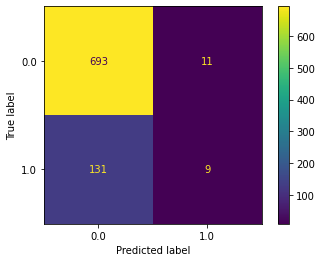

In [183]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test_scaled, y_test)
plt.show()

In the confusion matrix, you can see that even though our model has a decent precision (45%) it's still not good because it's actually predicting very rarely. The test data is ~3 years of BTC/USD price changes so it wouldn't make an incredible profit with predictions that rare.

Let's test for fun how our model would do in predicting short positions in ETH/USD with 5 years of data.

In [184]:
conn = sqlite3.connect('eth_megadb_short.sqlite')
df = pd.read_sql_query("SELECT * from prices", conn)

df = df.join(make_lags("adx", df.adx, lags=10))
df = df.join(make_lags("dmp", df.dmp, lags=10))
df = df.join(make_lags("dmn", df.dmn, lags=10))
df = df.join(make_lags("rsi", df.rsi, lags=10))
df = df.join(make_lags("slowd", df.slowd, lags=10))
df = df.join(make_lags("slowk", df.slowk, lags=10))

df['target'] = df['target'].shift(-10)
df.dropna(inplace=True)

X_eth = df.drop(["name", "target", "date", "id", "close", "low", "high"], axis=1)
X_eth_scaled = scaler.transform(X_eth)
y_eth = df["target"]

y_eth_pred = model.predict(X_eth_scaled) > 0.5
precision_score(y_eth, y_eth_pred)

0.42857142857142855

/home/olli/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


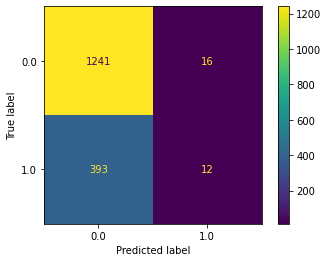

In [185]:
plot_confusion_matrix(model, X_eth_scaled, y_eth)
plt.show()

The same problem remains. Even though it's great to see that our XGBoost model does generalize to ETH/USD price changes, I would prefer it to predict a lot more often. You can see that there are actually 405 true short positions but our model only predicts 28 times.